<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/fuzzyLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-fuzzy -q

# Install Hugging Face libraries
!pip install  --upgrade transformers datasets accelerate evaluate bitsandbytes --quiet

!pip install --upgrade optimum -q

!pip install textblob -q

In [ ]:
import logging
import numpy as np
import torch
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig, BitsAndBytesConfig

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


# Hugging Face model id
model_id = "mistralai/Mistral-7B-Instruct-v0.1"

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    # attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
)


tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
tokenizer.padding_side = "right"  # to prevent warnings

# We redefine the pad_token and pad_token_id with out of vocabulary token (unk_token)
tokenizer.pad_token = tokenizer.unk_token
tokenizer.pad_token_id = tokenizer.unk_token_id



model.generation_config.pad_token_id = tokenizer.pad_token_id

generation_config = GenerationConfig(
            max_new_tokens=100,
            temperature=0.7,
            top_k=50,
        )

In [18]:
# Example usage:
prompt = "What is the capital of France?"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
outputs = model.generate(
    **inputs,
    generation_config=generation_config
)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

What is the capital of France?
A: Paris


Prompt:  Once upon a time, in a land far away
0.7913141634980986


Generated Text: Once upon a time, in a land far away, there was a beautiful kingdom ruled by a gracious and benevolent king. The kingdom was prosperous and the people were content. The king had one daughter, a Princess named Isadora.

The Princess was a gentle spirit and was loved by all. She had a gift for music and spent her days in the palace garden writing songs and playing her lyre.

The king longed to find a suitable husband for his daughter, one who would make her happy. He invited princes from all over the land to come and see his daughter, but none of them impressed him.

One day, a young man arrived at the palace gates. He was tall and handsome, but there was something different about him. When the king inquired about him, he was told that he was a poor farmer who had saved enough money from his daily labor to travel to the kingdom.

The king was surprised and intrigued by this. He invited the young man to com

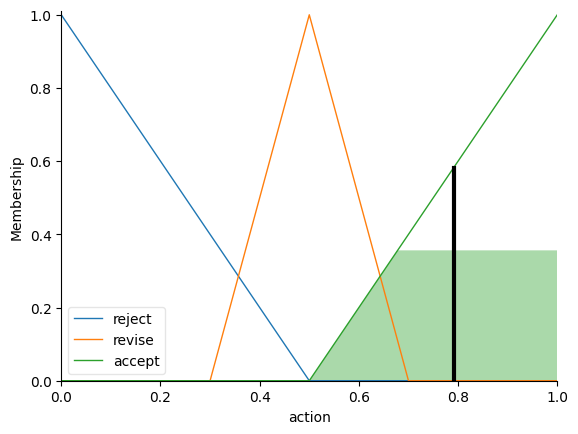

In [17]:
# Define linguistic variables for LLM confidence and sentiment score
confidence = ctrl.Antecedent(np.arange(0, 1.1, 0.1), "confidence")
sentiment = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), "sentiment")
action = ctrl.Consequent(np.arange(0, 1.1, 0.1), "action")

# Define membership functions for each variable
confidence["low"] = fuzz.trimf(confidence.universe, [0, 0, 0.5])
confidence["medium"] = fuzz.trimf(confidence.universe, [0.3, 0.5, 0.7])
confidence["high"] = fuzz.trimf(confidence.universe, [0.5, 1, 1])

sentiment["negative"] = fuzz.trimf(sentiment.universe, [-1, -1, 0])
sentiment["neutral"] = fuzz.trimf(sentiment.universe, [-0.5, 0, 0.5])
sentiment["positive"] = fuzz.trimf(sentiment.universe, [0, 1, 1])

action["reject"] = fuzz.trimf(action.universe, [0, 0, 0.5])
action["revise"] = fuzz.trimf(action.universe, [0.3, 0.5, 0.7])
action["accept"] = fuzz.trimf(action.universe, [0.5, 1, 1])

# Define fuzzy rules
rule1 = ctrl.Rule(confidence["low"] & sentiment["negative"], action["reject"])
rule2 = ctrl.Rule(confidence["medium"] & sentiment["negative"], action["revise"])
rule3 = ctrl.Rule(confidence["high"] & sentiment["negative"], action["revise"])
rule4 = ctrl.Rule(confidence["low"] & sentiment["neutral"], action["revise"])
rule5 = ctrl.Rule(confidence["medium"] & sentiment["neutral"], action["revise"])
rule6 = ctrl.Rule(confidence["high"] & sentiment["neutral"], action["accept"])
rule7 = ctrl.Rule(confidence["low"] & sentiment["positive"], action["revise"])
rule8 = ctrl.Rule(confidence["medium"] & sentiment["positive"], action["accept"])
rule9 = ctrl.Rule(confidence["high"] & sentiment["positive"], action["accept"])

# Create and simulate the control system
action_ctrl = ctrl.ControlSystem(
    [rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9]
)


action_sim = ctrl.ControlSystemSimulation(action_ctrl)



def estimate_confidence(text, model, tokenizer):
    """Estimates the confidence score of the generated text using token probabilities.

    Args:
      text: The generated text.
      model: The Mistral language model.
      tokenizer: The Mistral tokenizer.

    Returns:
      A float representing the confidence score (between 0 and 1).
    """
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)  # Remove labels argument
    logits = outputs.logits[:, :-1, :]  # Exclude logits for the last token
    probabilities = torch.softmax(logits, dim=-1)
    # Calculate the average probability of the generated tokens
    avg_prob = torch.mean(torch.max(probabilities, dim=-1).values).item()
    return avg_prob


#def analyze_sentiment(text):
    """Analyzes the sentiment of the generated text.

    (Replace this with your actual sentiment analysis implementation)

    Args:
      text: The generated text.

    Returns:
      A float representing the sentiment score (between -1 and 1).
    """
    # Placeholder implementation: returns a random sentiment score
#    return np.random.uniform(-1, 1)


from textblob import TextBlob

def analyze_sentiment(text):
    """Analyzes the sentiment of the generated text using TextBlob."""
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Returns a score between -1 and 1

def generate_text(prompt, confidence_threshold=0.7, max_new_tokens=500):
    """Generates text using the Mistral 7B model and evaluates it with a FIS.

    Args:
      prompt: The input prompt for text generation.
      confidence_threshold: The minimum confidence score for accepting text.
      max_new_tokens: The maximum number of tokens to generate.

    Returns:
      A tuple containing the generated text and the action taken
      (accept, revise, or reject).
    """

    inputs = tokenizer(prompt, return_tensors="pt")
    # Use GenerationConfig for text generation parameters
    generation_config = GenerationConfig(max_new_tokens=max_new_tokens, do_sample=True)
    outputs = model.generate(**inputs, generation_config=generation_config)

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    confidence_score = estimate_confidence(generated_text, model, tokenizer)
    sentiment_score = analyze_sentiment(generated_text)

    action_sim.input["confidence"] = confidence_score
    action_sim.input["sentiment"] = sentiment_score
    action_sim.compute()

    # Print the output (action to take)
    print(action_sim.output["action"])
    action.view(sim=action_sim)  # Display the FIS output graphically

    action_taken = "accept"  # Default action
    if action_sim.output["action"] < 0.5:
        action_taken = "reject"
    elif action_sim.output["action"] < 0.7:
        action_taken = "revise"

    return generated_text, action_taken


# Example usage:
prompt = "Once upon a time, in a land far away"
print('Prompt: ',prompt)
generated_text, action_taken = generate_text(prompt)
print('\n')
print("Generated Text:", generated_text)
print("Action Taken:", action_taken)
print('\n')